In [1]:
import timm
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from cod.train import train_model
from cod.tools import set_seed
from cod.split import convert_to_fbx, train_val_split
from cod.Transform import get_transforms
from cod.Dataset import MyDataset
from cod.tools import creat_snp_folder_path
from cod.tools import show_train
from cod.tools import freezing_body_model

## Константы

In [2]:
SIZE = 224
dirdata = "data\OxfordPets/"
train_files = "train.csv"
val_files = "val.csv"
test_files = "test.csv"
batch_size = 100
num_workers = 1
seed = 100
N_Class=37
num_epochs=20
lr = 0.001
classification_criterion=torch.nn.CrossEntropyLoss()


# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

In [3]:
# # Получаем датасет

# from urllib import request
# import os
# import tarfile
# if not os.path.exists('./data/OxfordPets'): os.makedirs('./data/OxfordPets')

# request.urlretrieve("https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz", "OxfordPets.tar.gz")
# request.urlretrieve("https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz", "OxfordPets_anotation.tar.gz")

# file = tarfile.open('OxfordPets.tar.gz')
# file.extractall('./data/OxfordPets')
# file.close()
# os.remove("OxfordPets.tar.gz")

# file = tarfile.open('OxfordPets_anotation.tar.gz')
# file.extractall('./data/OxfordPets')
# file.close()

# set_seed(seed)
# convert_to_fbx("data/OxfordPets/annotations/test.txt","data\OxfordPets/test.csv")
# convert_to_fbx("data/OxfordPets/annotations/trainval.txt","data\OxfordPets/trainval.csv")
# train_val_split("data\OxfordPets","trainval.csv")

# os.remove("OxfordPets_anotation.tar.gz")
# os.remove("data\OxfordPets/trainval.csv")

In [4]:
val_transforms, train_transforms = get_transforms(SIZE)
train_data = MyDataset(os.path.join(dirdata,train_files), dirdata, train_transforms)
val_data = MyDataset(os.path.join(dirdata,val_files), dirdata, val_transforms)
test_data = MyDataset(os.path.join(dirdata,test_files), dirdata, val_transforms)
test_data_binary = MyDataset(os.path.join(dirdata,test_files), dirdata, val_transforms, is_dog_cat = True, last_cat = 12)
train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False, sampler=train_data.getSampler(name_clases = "multiclass"))
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)
test_dataloader_binary = DataLoader(test_data_binary, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)

Для визуализации изображений используйте функцию:

# Загрузка пред обученых моделей и заморозка их тел

In [5]:
model_resnet=timm.create_model('resnet18', num_classes=N_Class, pretrained=True)
model_vgg16=timm.create_model('vgg16', num_classes=N_Class, pretrained=True)
model_vgg19=timm.create_model('vgg19', num_classes=N_Class, pretrained=True)


model_resnet = freezing_body_model(model_resnet)
model_vgg16 = freezing_body_model(model_vgg16)
model_vgg19 = freezing_body_model(model_vgg19)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\vgg16-397923af.pth
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


fc Linear(in_features=512, out_features=37, bias=True)
head.fc Linear(in_features=4096, out_features=37, bias=True)
head.fc Linear(in_features=4096, out_features=37, bias=True)


## Визуализация данных

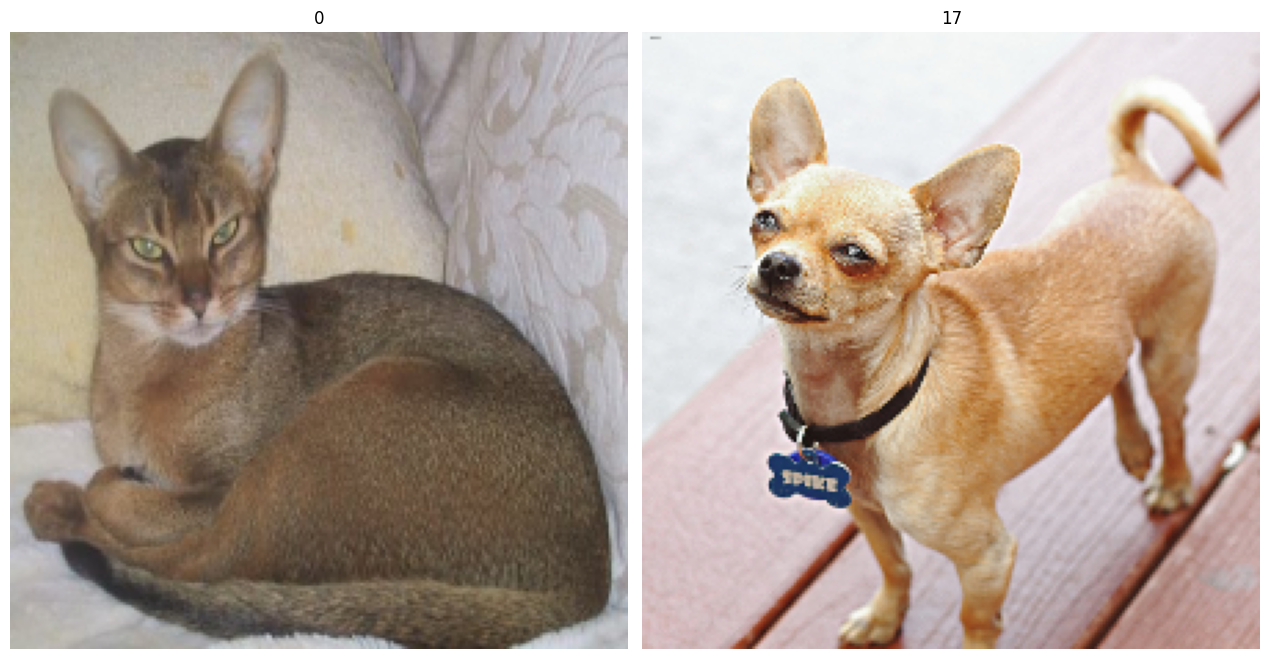

In [6]:
def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

image_cat, label_cat = val_data.__getitem__(1)
image_dog, label_dog  = val_data.__getitem__(100)

image_cat = image_cat.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_cat = std * image_cat + mean

image_dog = image_dog.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_dog = std * image_dog + mean

display_images([image_cat,image_dog], [label_cat, label_dog])

# Обучение

### Обучение на основе VGG-16

In [7]:
dataloaders={'T':train_dataloader,
             'V':val_dataloader}
phases=['T','V']
top_k = {'T':1, 'V':1}
model = model_vgg16
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)
snp_path =creat_snp_folder_path(model_name = "vgg16",Dataset_name="OxfordPets")
_,best_model_the_acc_classification,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)

Training complete in 11m 36s
Best V Loss: 0.3264, epoch 12  
Best V Acc : 0.8886, epoch 4
Epoch 1/20
----------
T Loss: 1.9306 Acc: 0.4831
V Loss: 0.4998 Acc: 0.8371
Epoch 2/20
----------
T Loss: 1.1962 Acc: 0.6503
V Loss: 0.4277 Acc: 0.8500
Epoch 3/20
----------
T Loss: 1.1576 Acc: 0.6621
V Loss: 0.3940 Acc: 0.8629
Epoch 4/20
----------
T Loss: 1.0384 Acc: 0.6831
V Loss: 0.3699 Acc: 0.8886
Epoch 5/20
----------
T Loss: 0.9796 Acc: 0.7062
V Loss: 0.3510 Acc: 0.8771
Epoch 6/20
----------
T Loss: 1.0329 Acc: 0.6910
V Loss: 0.3371 Acc: 0.8771
Epoch 7/20
----------
T Loss: 0.9510 Acc: 0.7183
V Loss: 0.3591 Acc: 0.8786
Epoch 8/20
----------
T Loss: 0.9089 Acc: 0.7183
V Loss: 0.3626 Acc: 0.8814
Epoch 9/20
----------
T Loss: 0.9189 Acc: 0.7310
V Loss: 0.4021 Acc: 0.8571
Epoch 10/20
----------
T Loss: 0.8653 Acc: 0.7362
V Loss: 0.3521 Acc: 0.8829
Epoch 11/20
----------
T Loss: 0.8803 Acc: 0.7341
V Loss: 0.3558 Acc: 0.8743
Epoch 12/20
----------
T Loss: 0.8584 Acc: 0.7397
V Loss: 0.3264 Acc: 0.

### Визуализация хода обучения

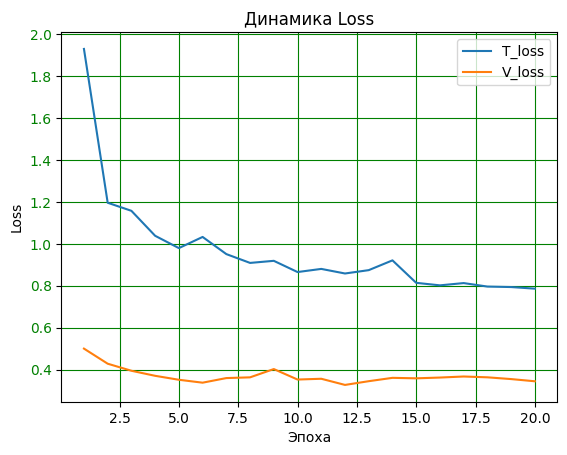

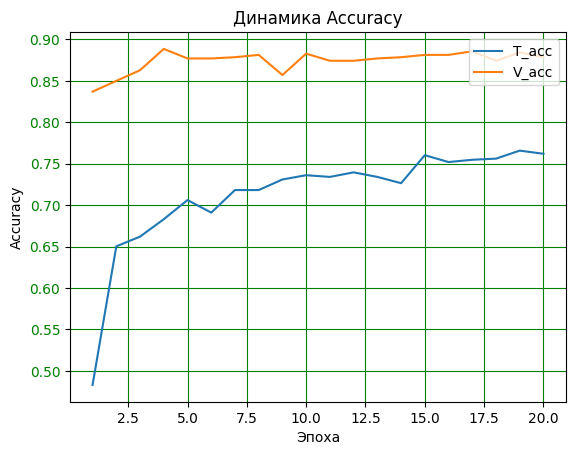

In [8]:
show_train(snp_path + "log.csv")

### Расчёт точности классификатора на основе VGG-16

In [9]:
dataloaders={'Top_1':test_dataloader,
             'Top_3':test_dataloader,
             'Top_5':test_dataloader,
             'Top_1_binary':test_dataloader_binary}
phases=['Top_1','Top_3','Top_5','Top_1_binary']
top_k={'Top_1':1,'Top_3':3,'Top_5':5,'Top_1_binary':1}

model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
snp_path =creat_snp_folder_path(model_name = "vgg16",Dataset_name="OxfordPets")
optimizer_ft =optim.AdamW(model.parameters(), lr = 0)
exp_lr_scheduler = None
_,_,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)


Training complete in 2m 1s
Best Top_1 Loss: 0.4081, epoch 0  
Best Top_1 Acc : 0.8661, epoch 0
Best Top_3 Loss: 0.4081, epoch 0  
Best Top_3 Acc : 0.9792, epoch 0
Best Top_5 Loss: 0.4081, epoch 0  
Best Top_5 Acc : 0.9925, epoch 0
Best Top_1_binary Loss: 0.3348, epoch 0  
Best Top_1_binary Acc : 0.9936, epoch 0
Epoch 1/1
----------
Top_1 Loss: 0.4081 Acc: 0.8661
Top_3 Loss: 0.4081 Acc: 0.9792
Top_5 Loss: 0.4081 Acc: 0.9925
Top_1_binary Loss: 0.3348 Acc: 0.9936



### Обучение на основе VGG-19

In [11]:
set_seed(seed)
dataloaders={'T':train_dataloader,
             'V':val_dataloader}
phases=['T','V']
top_k = {'T':1, 'V':1}
model = model_vgg19
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)
snp_path =creat_snp_folder_path(model_name = "vgg19",Dataset_name="OxfordPets")
_,best_model_the_acc_classification,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)


Training complete in 11m 44s
Best V Loss: 0.3140, epoch 15  
Best V Acc : 0.8900, epoch 14
Epoch 1/20
----------
T Loss: 0.8922 Acc: 0.7269
V Loss: 0.4072 Acc: 0.8586
Epoch 2/20
----------
T Loss: 0.8732 Acc: 0.7314
V Loss: 0.3912 Acc: 0.8729
Epoch 3/20
----------
T Loss: 1.0968 Acc: 0.6710
V Loss: 0.3752 Acc: 0.8743
Epoch 4/20
----------
T Loss: 1.0186 Acc: 0.6976
V Loss: 0.3734 Acc: 0.8757
Epoch 5/20
----------
T Loss: 1.0571 Acc: 0.6852
V Loss: 0.3510 Acc: 0.8714
Epoch 6/20
----------
T Loss: 0.9322 Acc: 0.7110
V Loss: 0.3700 Acc: 0.8700
Epoch 7/20
----------
T Loss: 0.9649 Acc: 0.7021
V Loss: 0.3720 Acc: 0.8700
Epoch 8/20
----------
T Loss: 0.9131 Acc: 0.7221
V Loss: 0.3529 Acc: 0.8671
Epoch 9/20
----------
T Loss: 0.8885 Acc: 0.7210
V Loss: 0.3716 Acc: 0.8671
Epoch 10/20
----------
T Loss: 0.8955 Acc: 0.7366
V Loss: 0.3776 Acc: 0.8714
Epoch 11/20
----------
T Loss: 0.8198 Acc: 0.7469
V Loss: 0.3534 Acc: 0.8786
Epoch 12/20
----------
T Loss: 0.8894 Acc: 0.7266
V Loss: 0.3598 Acc: 0

### Визуализация хода обучения

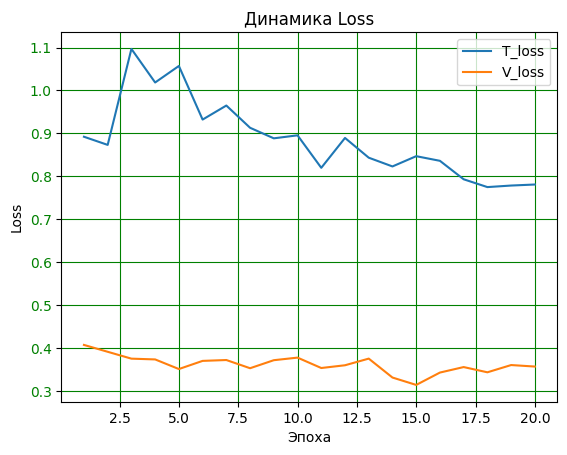

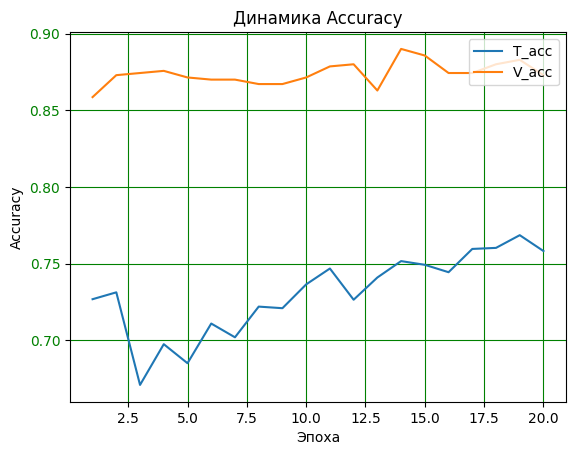

In [12]:
show_train(snp_path + "log.csv")

### Расчёт точности классификатора на основе VGG-19

In [13]:
dataloaders={'Top_1':test_dataloader,
             'Top_3':test_dataloader,
             'Top_5':test_dataloader,
             'Top_1_binary':test_dataloader_binary}
phases=['Top_1','Top_3','Top_5','Top_1_binary']
top_k={'Top_1':1,'Top_3':3,'Top_5':5,'Top_1_binary':1}
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
snp_path =creat_snp_folder_path(model_name = "vgg19",Dataset_name="OxfordPets")
optimizer_ft =optim.AdamW(model.parameters(), lr = 0)
exp_lr_scheduler = None
_,_,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)


Training complete in 1m 53s
Best Top_1 Loss: 0.4167, epoch 0  
Best Top_1 Acc : 0.8681, epoch 0
Best Top_3 Loss: 0.4167, epoch 0  
Best Top_3 Acc : 0.9756, epoch 0
Best Top_5 Loss: 0.4167, epoch 0  
Best Top_5 Acc : 0.9900, epoch 0
Best Top_1_binary Loss: 0.3323, epoch 0  
Best Top_1_binary Acc : 0.9925, epoch 0
Epoch 1/1
----------
Top_1 Loss: 0.4167 Acc: 0.8681
Top_3 Loss: 0.4167 Acc: 0.9756
Top_5 Loss: 0.4167 Acc: 0.9900
Top_1_binary Loss: 0.3323 Acc: 0.9925



### Обучение на основе ResNet

In [14]:
set_seed(seed)
dataloaders={'T':train_dataloader,
             'V':val_dataloader}
phases=['T','V']
top_k = {'T':1, 'V':1}
model = model_resnet
optimizer_ft =optim.AdamW(model.parameters(), lr = lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=100, gamma=1)
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="OxfordPets")
_,best_model_the_acc_classification,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            num_epochs,
            top_k)


Training complete in 9m 36s
Best V Loss: 0.4307, epoch 20  
Best V Acc : 0.8757, epoch 20
Epoch 1/20
----------
T Loss: 3.3124 Acc: 0.1352
V Loss: 2.4085 Acc: 0.4300
Epoch 2/20
----------
T Loss: 2.4969 Acc: 0.4086
V Loss: 1.5569 Acc: 0.7000
Epoch 3/20
----------
T Loss: 2.0602 Acc: 0.5138
V Loss: 1.1353 Acc: 0.8057
Epoch 4/20
----------
T Loss: 1.7803 Acc: 0.5866
V Loss: 0.8962 Acc: 0.8343
Epoch 5/20
----------
T Loss: 1.6252 Acc: 0.6097
V Loss: 0.7836 Acc: 0.8400
Epoch 6/20
----------
T Loss: 1.4848 Acc: 0.6203
V Loss: 0.6945 Acc: 0.8371
Epoch 7/20
----------
T Loss: 1.4604 Acc: 0.6200
V Loss: 0.6534 Acc: 0.8557
Epoch 8/20
----------
T Loss: 1.3664 Acc: 0.6414
V Loss: 0.5922 Acc: 0.8457
Epoch 9/20
----------
T Loss: 1.3074 Acc: 0.6538
V Loss: 0.5698 Acc: 0.8514
Epoch 10/20
----------
T Loss: 1.2942 Acc: 0.6634
V Loss: 0.5484 Acc: 0.8543
Epoch 11/20
----------
T Loss: 1.2138 Acc: 0.6655
V Loss: 0.5227 Acc: 0.8586
Epoch 12/20
----------
T Loss: 1.2342 Acc: 0.6621
V Loss: 0.5063 Acc: 0.

### Визуализация хода обучения

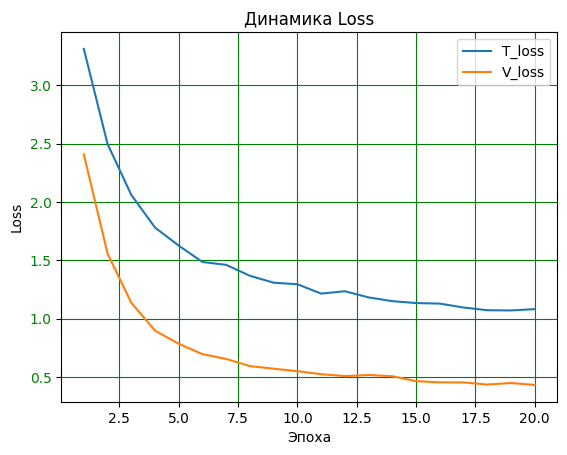

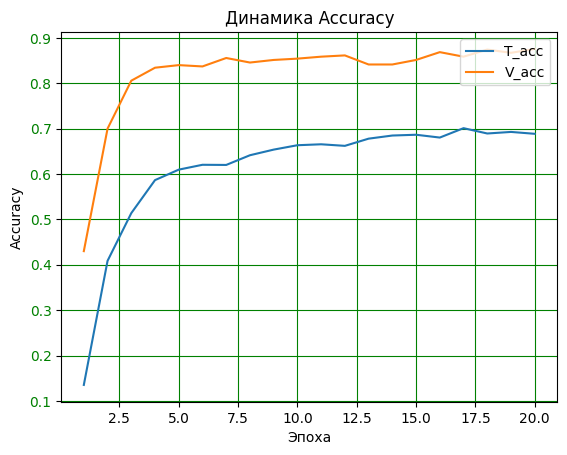

In [15]:
show_train(snp_path + "log.csv")

In [ ]:
# weights = torch.load("snp\OxfordPets/resnet18/06_05_2023/20_05_54/17_V_ACC top1-0.8814_checkpoint.tar", map_location='cpu')
# model.load_state_dict(weights['state_dict'], strict=True)

<All keys matched successfully>

### Расчёт точности классификатора на основе ResNet

In [16]:
model = model_resnet
dataloaders={'Top_1':test_dataloader,
             'Top_3':test_dataloader,
             'Top_5':test_dataloader,
             'Top_1_binary':test_dataloader_binary}
phases=['Top_1','Top_3','Top_5','Top_1_binary']
top_k={'Top_1':1,'Top_3':3,'Top_5':5,'Top_1_binary':1}
model.load_state_dict(best_model_the_acc_classification['V'], strict=True)
snp_path =creat_snp_folder_path(model_name = "resnet18",Dataset_name="OxfordPets")
optimizer_ft =optim.AdamW(model.parameters(), lr = 0)
exp_lr_scheduler = None
_,_,_  =train_model(model,
            classification_criterion, 
            optimizer_ft, 
            dataloaders,
            exp_lr_scheduler,
            batch_size, 
            snp_path, 
            1,
            top_k,
            phases)


Training complete in 1m 23s
Best Top_1 Loss: 0.4909, epoch 0  
Best Top_1 Acc : 0.8583, epoch 0
Best Top_3 Loss: 0.4909, epoch 0  
Best Top_3 Acc : 0.9689, epoch 0
Best Top_5 Loss: 0.4909, epoch 0  
Best Top_5 Acc : 0.9881, epoch 0
Best Top_1_binary Loss: 0.3430, epoch 0  
Best Top_1_binary Acc : 0.9881, epoch 0
Epoch 1/1
----------
Top_1 Loss: 0.4909 Acc: 0.8583
Top_3 Loss: 0.4909 Acc: 0.9689
Top_5 Loss: 0.4909 Acc: 0.9881
Top_1_binary Loss: 0.3430 Acc: 0.9881



```
Top_1 Loss: 0.4969 Acc: 0.8589
Top_3 Loss: 0.4969 Acc: 0.9744
Top_5 Loss: 0.4969 Acc: 0.9883
Top_1_binary Loss: 0.3443 Acc: 0.9875
